building off stocks.ipynb, this is a document working on getting a prediction for apple stock using yfinance and such.

In [93]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

In [94]:
#importing the data using yfinance and display
apple_stock = yf.Ticker("AAPL")
apple_stock = apple_stock.history(period = "max")
apple_stock = apple_stock.loc["2000-01-01":].copy()
apple_stock.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-01-03 00:00:00-05:00,0.787983,0.845274,0.764034,0.841048,535796800,0.0,0.0
2000-01-04 00:00:00-05:00,0.813341,0.831186,0.760277,0.770139,512377600,0.0,0.0
2000-01-05 00:00:00-05:00,0.779530,0.830716,0.773895,0.781408,778321600,0.0,0.0
2000-01-06 00:00:00-05:00,0.797375,0.803949,0.713787,0.713787,767972800,0.0,0.0
2000-01-07 00:00:00-05:00,0.725057,0.758869,0.717544,0.747598,460734400,0.0,0.0


In [95]:
#adding a predict column
apple_stock["Tomorrow"] = apple_stock["Close"].shift(-1)
apple_stock["Target"] = (apple_stock["Tomorrow"] > apple_stock["Close"]).astype(int)
apple_stock.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Tomorrow,Target
Date,,,,,,,,,
2000-01-03 00:00:00-05:00,0.787983,0.845274,0.764034,0.841048,535796800,0.0,0.0,0.770139,0
2000-01-04 00:00:00-05:00,0.813341,0.831186,0.760277,0.770139,512377600,0.0,0.0,0.781408,1
2000-01-05 00:00:00-05:00,0.779530,0.830716,0.773895,0.781408,778321600,0.0,0.0,0.713787,0
2000-01-06 00:00:00-05:00,0.797375,0.803949,0.713787,0.713787,767972800,0.0,0.0,0.747598,1
2000-01-07 00:00:00-05:00,0.725057,0.758869,0.717544,0.747598,460734400,0.0,0.0,0.734449,0


<Axes: xlabel='Date', ylabel='Close'>

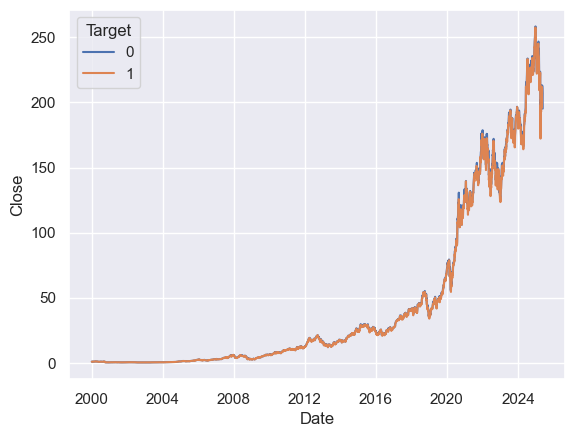

In [96]:
#graphing the data
sns.set_theme(style = "darkgrid")
sns.lineplot(x = apple_stock.index, 
             y = apple_stock["Close"],
             hue = apple_stock["Target"])

In [97]:
model = RandomForestClassifier(n_estimators = 200, 
                               min_samples_split = 50, 
                               random_state = 1)

train = apple_stock.iloc[:-100]
test = apple_stock.iloc[-100:]

predictors = ["Open","High","Low","Close","Volume","Dividends","Stock Splits"]
model.fit(train[predictors],train["Target"])

RandomForestClassifier(min_samples_split=50, n_estimators=200, random_state=1)

In [98]:
predicted_values = model.predict(test[predictors])
predicted_values = pd.Series(predicted_values, index = test.index)
precision_score(test["Target"],predicted_values)

0.42857142857142855

Adding backtesting

In [99]:
#prediction speedup

def predict(train,test,predictors,model):
    model.fit(train[predictors],train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index = test.index, name = "Predictions")
    combined = pd.concat([test["Target"],preds],axis = 1)
    return combined

In [100]:
#backtesting

def backtest(data,model,predictors,start=2500, step=250):
    all_predictions = []
    for i in range(start,data.shape[0],step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train,test,predictors,model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [101]:
predictions = backtest(apple_stock,model,predictors)
predictions["Predictions"].value_counts()

Predictions
0    2363
1    1524
Name: count, dtype: int64

In [102]:
precision_score(predictions["Target"],predictions["Predictions"])

0.5229658792650919

In [103]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.529972
0    0.470028
Name: count, dtype: float64

adding more features

In [104]:
horizons = [2,5,20,60,250,1000]
new_predictors = ["Open","High","Low","Close","Volume"]

for horizon in horizons:
    rolling_averages = apple_stock.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    apple_stock[ratio_column] = apple_stock["Close"] / rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    apple_stock[trend_column] = apple_stock.shift(1).rolling(horizon).sum()["Target"]

    new_predictors += [ratio_column, trend_column]

apple_stock = apple_stock.dropna()
apple_stock.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Tomorrow,Target,Close_Ratio_2,...,Close_Ratio_5,Trend_5,Close_Ratio_20,Trend_20,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,,,,,
2003-12-26 00:00:00-05:00,0.305801,0.314217,0.305651,0.312263,103695200,0.0,0.0,0.317823,1,1.008983,...,1.033316,3.0,1.008908,9.0,0.951842,28.0,1.123531,129.0,0.801992,471.0
2003-12-29 00:00:00-05:00,0.314217,0.317973,0.313465,0.317823,233458400,0.0,0.0,0.319777,1,1.008825,...,1.036766,4.0,1.026277,9.0,0.968363,29.0,1.141855,129.0,0.817223,472.0
2003-12-30 00:00:00-05:00,0.318274,0.323083,0.317823,0.319777,204853600,0.0,0.0,0.321129,1,1.003063,...,1.028715,4.0,1.033662,9.0,0.974619,29.0,1.147266,129.0,0.823222,472.0
2003-12-31 00:00:00-05:00,0.320829,0.323533,0.318274,0.321129,174451200,0.0,0.0,0.319777,0,1.002110,...,1.017716,5.0,1.038462,10.0,0.979429,29.0,1.150513,129.0,0.827540,473.0
2004-01-02 00:00:00-05:00,0.323833,0.326839,0.318274,0.319777,144642400,0.0,0.0,0.333151,1,0.997890,...,1.005101,4.0,1.033461,10.0,0.976752,28.0,1.144096,129.0,0.824965,472.0


In [105]:
def predict_proba(train,test,predictors,model):
    model.fit(train[predictors],train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >= 0.6] = 1
    preds[preds < 0.6] = 0
    preds = pd.Series(preds, index = test.index, name = "Predictions")
    combined = pd.concat([test["Target"],preds],axis = 1)
    return combined

In [106]:
def backtest_proba(data,model,predictors,start=2500, step=250):
    all_predictions = []
    for i in range(start,data.shape[0],step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict_proba(train,test,predictors,model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [107]:
predictions = backtest_proba(apple_stock,model,new_predictors)
predictions["Predictions"].value_counts()

Predictions
0.0    2608
1.0     278
Name: count, dtype: int64

In [108]:
precision_score(predictions["Target"],predictions["Predictions"])

0.5215827338129496